## map2loop: From geology layers to outputs to various 3D modelling programs- Hamersley example-gempy

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault and fold axial trace  polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into gempy to make a 3D model 

<img src='../graphics/map_sm.png'>

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon

sys.path.append('../')
sys.path.append('../../gempy/')

from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
import gempy as gp
%matplotlib inline

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )
gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
print(os.getenv('PROJ_LIB'))
print(os.getcwd())


m2l_utils.v()

Current Working Directory 
*** /Users/varga/.conda/envs/gempy/share/gdal
is dir: True
is file: True
is readable: True
/Users/varga/.conda/envs/gempy/share/proj
/Users/varga/PycharmProjects/map2loop/notebooks
0.0.50


## Create bounding box based on inputs

In [3]:
test_data_name='test_data3'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "../test_data3/m2l_config.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_top=1200
model_base=-8200

#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)

test_data_path='../test_data3/'

geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
mindep_file='mindeps_2018.shp' #input mineral deposit file (if local)

#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#CODES AND LABELS 
# these refer to specific fields (

In [4]:

fold_decimate=2         

contact_decimate=5

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

    
local_paths=True              #use local copies of data

pluton_form='domes'

fault_dip=90.0

min_fault_length=20

## First we test to see if we have access to the online data we need


In [ ]:
loopwfs=m2l_utils.have_access("geo.waxi-gis.org")
hawaii=m2l_utils.have_access("pae-paha.pacioos.hawaii.edu")

if(not (loopwfs & hawaii)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

## Optional WFS source
  
WFS brings in field names as lower case, so need to redefine codes too

## Plot geology polygons and bounding box

In [ ]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save to file as WKT

In [ ]:
hint_flag=True # use GSWA strat database to provide relative age hints
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'], 
                       c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

## Read and save WAROX point data as WKT

In [ ]:
warox = gpd.read_file(structure_file,bbox=bbox)

sub_pts = warox[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

In [ ]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [ ]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

## Create map2model input file

In [ ]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,
                          structure_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE')


## Calculate topology

In [ ]:
import subprocess
import platform
os.chdir(m2m_cpp_path)
print(os.getcwd())

if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe", "Parfile"], capture_output=True)
else:
    subprocess.run(["./map2model", "Parfile"], capture_output=True)


## Simple network graph of the geology with legend

In [ ]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Topology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

In [ ]:
from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/map2loop/notebooks/2.%20map2loop_after_topology.ipynb

## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently mostly hardwired to GSWA 500K map so needs work...</font>


In [ ]:
os.chdir('../map2loop')

print(os.getcwd())

In [ ]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


#print(os.getcwd())
#os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


## Next we define an area of interest and some other basic stuff

In [ ]:
print(os.getcwd())
#test_data_path='../test_data3/'


#%run -i "../test_data3/m2l_config.py"

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


#contact_decimate=5

## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

In [ ]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
if((not local_paths) and net):     
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)



## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

In [ ]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

In [ ]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs
#display(faults)
sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## Clip geology, faults, structures and map geology to structures

In [ ]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]
#display(sfcode)
all_folds=faults[faults[c_l['f']].str.contains(c_l['fold'])]
folds_clip=m2l_utils.clip_shp(all_folds,polygo)
folds_clip.to_file(tmp_path+'folds_clip.shp')


all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]



#display(structure_code)
geol_clip=m2l_utils.clip_shp(geology, polygo)
faults_clip=m2l_utils.clip_shp(all_faults,polygo)
#display(faults_clip)
structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['t'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')

geol_clip.to_file(tmp_path+'geol_clip.shp')
faults_clip.to_file(tmp_path+'faults_clip.shp')
structure_clip.to_file(tmp_path+'structure_clip.shp')


## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

In [ ]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up :

<img src='../graphics/polarity.png'>

Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

In [ ]:
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.save_orientations(structure_code,output_path,c_l,orientation_decimate,dtm)


## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [ ]:

m2l_geometry.create_orientations( tmp_path, output_path, dtm,geol_clip,structure_clip,c_l)

## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [ ]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,geol_clip,contact_decimate,c_l,intrusion_mode)

## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [ ]:
#display(ls_dict)

In [ ]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

## Remove faults from decimated basal contacts as save as csv file  


In [ ]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,contact_decimate,c_l)

#m2l_geometry.save_contacts_with_faults_removed(tmp_path+'faults_clip.shp',output_path,10,ls_dict,ls_dict_decimate,c_l,dst_crs,dtm)

## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data

In [ ]:
m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,c_l,fault_decimate,min_fault_length,fault_dip)


use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) ################# MOVE UP   #########################
use_gcode2=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) ################# MOVE UP   #########################

m2l_interpolation.process_fault_throw_and_near_orientations(tmp_path,output_path,dtm_reproj_file,c_l,use_gcode,use_gcode2,dst_crs,bbox,scheme)

## Estimate formation thickness and normalised formation thickness

contact_decimate=2

geology_file=tmp_path+'basal_contacts.shp'
bbox=(minx,miny,maxx,maxy)
dtm = rasterio.open(dtm_reproj_file)
null_scheme='null'
buffer =5000
max_thickness_allowed=10000

m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,bbox,c_l,null_scheme,contact_decimate)

m2l_geometry.calc_thickness(tmp_path,output_path,buffer,max_thickness_allowed,c_l)

m2l_geometry.normalise_thickness(output_path)

## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [ ]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,pluton_form,pluton_dip,contact_decimate,c_l)


## Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for poulating parts of maps where little structural data is available

In [ ]:
use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) ################# MOVE UP   #########################
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

In [ ]:
print(c_l['g'])
print(use_gcode)

In [ ]:
m2l_interpolation.interpolate_orientations(structure_file,tmp_path,bbox,c_l,use_gcode,scheme,gridx,gridy,False)

## Interpolates a regular grid from a shapefile of from contacts and saves out three csv files of l & m direction cosines and strike data

Can choose between various RBF and IDW options  

<font face color='red'>Best with basal contacts only, using Notebook #1 as this avoids intrusive  and fault contacts being considered</font>

In [ ]:
geology_file=tmp_path+'basal_contacts.shp'

dtm = rasterio.open(dtm_reproj_file)
use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) ################# MOVE UP   #########################


In [ ]:
m2l_interpolation.interpolate_contacts(geology_file,tmp_path,dtm,bbox,c_l,use_gcode,scheme,gridx,gridy,False)


## Combines rbf of contact orientations with rbf of dip/dipdir measurements

Uses normalised direction cosines **(l,m,n)**:  
- **l,m** from RBF of basal contact orientations  
- **signs of l & m** from misorientation with RBF of orientation data and  
- **n** from RBF of orientation data  
  
May be useful for adding data where no orientations are available (e.g. in fault bounded domains) and for calculating true thickness of layers. Assumes a 2D plane of data, but if 3D RBF was calulated and projected contact info was used it should apply with topography too. 

In [ ]:
geology_file=tmp_path+'geol_clip.shp'
combo_file=tmp_path+'combo.csv'

lc=np.loadtxt(tmp_path+'interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
mc=np.loadtxt(tmp_path+'interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
lo=np.loadtxt(tmp_path+'interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
mo=np.loadtxt(tmp_path+'interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
no=np.loadtxt(tmp_path+'interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
xy=np.loadtxt(tmp_path+'interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

In [ ]:
m2l_interpolation.join_contacts_and_orientations(combo_file,geology_file,tmp_path,dtm_reproj_file,c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox,False)


## Creates fold axial trace points

In [ ]:
## Creates fold axial trace points

m2l_geometry.save_fold_axial_traces(tmp_path+'folds_clip.shp',output_path,dtm,c_l,fold_decimate)

#Save fold axial trace near-hinge orientations
fat_step=750         # how much to step out normal to fold axial trace
close_dip=20.0       #dip to assign to all new orientations
   
m2l_geometry.save_fold_axial_traces_orientations(tmp_path+'folds_clip.shp',output_path,tmp_path,dtm,c_l,dst_crs,fold_decimate,fat_step,close_dip)


## Preprocess data to ensure it meets gempy's requirements

In [ ]:
if(local_paths): ###############FUDGE#############
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
else:
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PMI_7366',  'A_mgn_PRK_16193' ) ################# MOVE UP   #########################


#print('only processing',use_gcode)

#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations')

m2l_geometry.tidy_data(output_path,tmp_path,use_gcode,use_interpolations,use_fat,pluton_form,inputs)

In [ ]:
m2l_geometry.tidy_data??

## Analyse fault-fault topology

In [ ]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gempy test 


<font face color='red'>The way this loads data to gempy is not right, so all the units end up in one series... but it gives the basic idea </font>


## Now we define the basic model and load the orientation and lithological information
mj: We inset the model dimensions as once reprojects the edge pixels of the topography are undefined. Probably doesn't need to be that extreme (unit is metres). Could use parameter <b>maxtopo</b> to 

In [5]:
import importlib
importlib.reload(m2l_export)

<module 'map2loop.m2l_export' from '../map2loop/m2l_export.py'>

In [ ]:
#import winsound
# duration = 700  # milliseconds
# freq = 1100  # Hz
# #winsound.Beep(freq, duration)

# vtk=False

geo_model = m2l_export.loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
                                  output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',
                                  dtm_reproj_file,bbox,model_base, model_top,vtk)


In [ ]:
g = Out[67]

In [ ]:
g.surfaces

In [ ]:
gp.map_series_to_surfaces

In [59]:


import gempy as gp
from gempy import plot
geo_model = gp.create_model(test_data_name) 

# If depth coordinates are much smaller than XY the whole system of equations becomes very unstable. Until
# I fix it properly in gempy this is a handcrafted hack
ve = (bbox[0] - bbox[2]) / (model_base - model_top)

In [60]:
if ve < 3:
    ve = 1
else:
    print('The vertical exageration is: ', ve)

ve = 1
gp.init_data(geo_model, extent=[bbox[0], bbox[2], bbox[1], bbox[3], model_base, model_top],
        resolution = (50,50,50), 
      path_o = output_path+'orientations_clean.csv',
      path_i = output_path+'contacts_clean.csv', default_values=False); 
    

The vertical exageration is:  10.95436170212766
Active grids: ['regular']


In [61]:
geo_model.modify_surface_points(geo_model.surface_points.df.index, Z=geo_model.surface_points.df['Z']*ve)

X             Y             Z       X_r       Y_r       Z_r        surface          series  id  order_series    smooth
0     595340.779975  7.475217e+06   7098.426383  0.694578  0.338324  0.528429      A_mgn_PMI  Default series   1             1  0.000001
1     598240.030215  7.475074e+06   7087.472021  0.707451  0.337689  0.528380      A_mgn_PMI  Default series   1             1  0.000001
2     599321.509484  7.475170e+06   6988.882766  0.712253  0.338115  0.527942      A_mgn_PMI  Default series   1             1  0.000001
3     600440.668471  7.475132e+06   7251.787447  0.717223  0.337947  0.529110      A_mgn_PMI  Default series   1             1  0.000001
4     602892.489608  7.474514e+06   7054.608936  0.728109  0.335203  0.528234      A_mgn_PMI  Default series   1             1  0.000001
5     603028.000000  7.470669e+06   6660.251915  0.728711  0.318129  0.526483      A_mgn_PMI  Default series   1             1  0.000001
6     598870.970746  7.471334e+06   6616.434468  0.710253  0.321084  0.526289      A_mgn_PMI  Default series   1             1  0.000001
7     595450.588580  7.471556e+06   6846.476064  0.695065  0.322070  0.527310      A_mgn_PMI  Default series   1             1  0.000001
8     594340.540554  7.472034e+06   6999.837128  0.690136  0.324190  0.527991      A_mgn_PMI  Default series   1             1  0.000001
9     594252.800608  7.472428e+06   6999.837128  0.689747  0.325942  0.527991      A_mgn_PMI  Default series   1             1  0.000001
10    595744.767907  7.473248e+06   6725.978085  0.696371  0.329581  0.526775      A_mgn_PMI  Default series   1             1  0.000001
11    595833.290561  7.474476e+06   8062.410213  0.696764  0.335033  0.532709      A_mgn_PMI  Default series   1             1  0.000001
12    595536.420074  7.474910e+06   7098.426383  0.695446  0.336963  0.528429      A_mgn_PMI  Default series   1             1  0.000001
13    537833.390495  7.468177e+06   4578.923191  0.439227  0.307066  0.517241      A_mgn_PRK  Default series   2             1  0.000001
14    536494.879262  7.468121e+06   4611.786277  0.433284  0.306815  0.517387      A_mgn_PRK  Default series   2             1  0.000001
15    536291.339715  7.468097e+06   4611.786277  0.432380  0.306708  0.517387      A_mgn_PRK  Default series   2             1  0.000001
16    535602.888290  7.467757e+06   4907.554043  0.429323  0.305199  0.518701      A_mgn_PRK  Default series   2             1  0.000001
17    535436.628241  7.467567e+06   5006.143298  0.428585  0.304355  0.519138      A_mgn_PRK  Default series   2             1  0.000001
18    528876.531491  7.469505e+06   4666.558085  0.399456  0.312963  0.517631      A_mgn_PRK  Default series   2             1  0.000001
19    529840.861374  7.470353e+06   4830.873511  0.403738  0.316726  0.518360      A_mgn_PRK  Default series   2             1  0.000001
20    530440.311511  7.470687e+06   4819.919149  0.406400  0.318211  0.518312      A_mgn_PRK  Default series   2             1  0.000001
21    530487.429688  7.471234e+06   4852.782234  0.406609  0.320640  0.518457      A_mgn_PRK  Default series   2             1  0.000001
22    530182.251045  7.471255e+06   4852.782234  0.405254  0.320731  0.518457      A_mgn_PRK  Default series   2             1  0.000001
23    529971.908086  7.471154e+06   4885.645319  0.404320  0.320285  0.518603      A_mgn_PRK  Default series   2             1  0.000001
24    529374.769428  7.471291e+06   4852.782234  0.401669  0.320893  0.518457      A_mgn_PRK  Default series   2             1  0.000001
25    528281.030409  7.471303e+06   4808.964787  0.396812  0.320947  0.518263      A_mgn_PRK  Default series   2             1  0.000001
26    527306.358765  7.470971e+06   4918.508404  0.392484  0.319472  0.518749      A_mgn_PRK  Default series   2             1  0.000001
27    527242.572089  7.470921e+06   4918.508404  0.392201  0.319248  0.518749      A_mgn_PRK  Default series   2             1  0.000001
28    544669.619684  7.473028e+06   4852.7822

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[ 5.01086710e+05,  7.45647405e+06, -8.87960560e+04],
       [ 5.01086710e+05,  7.45647405e+06, -8.67366360e+04],
       [ 5.01086710e+05,  7.45647405e+06, -8.46772160e+04],
       ...,
       [ 6.01556986e+05,  7.56765822e+06,  3.93000000e+02],
       [ 6.02145391e+05,  7.56765822e+06,  3.93000000e+02],
       [ 6.02733797e+05,  7.56765822e+06,  3.91000000e+02]])

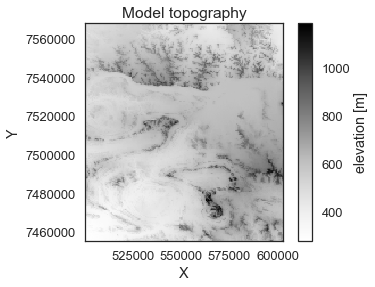

In [62]:
fp = dtm_reproj_file

geo_model.set_topography(source='gdal',filepath=fp)

In [63]:
# pile processing
contents=np.genfromtxt(tmp_path+'groups_clean.csv',
                       delimiter=',',dtype='U25')
ngroups=len(contents)

In [64]:
contents

array(['Shingle_Creek_Group', 'Turee_Creek_Group', 'Hamersley_Group',
       'Fortescue_Group', 'A_s_PMI', 'A_mgn_PMI', 'A_mgn_PRK'],
      dtype='<U25')

In [65]:
geo_model.add_series(contents)
#geo_model.delete_series(['Default series'])

order_series BottomRelation isActive
Default series                  1        Erosion     True
Basement                        2        Erosion    False
Shingle_Creek_Group             3        Erosion      NaN
Turee_Creek_Group               4        Erosion      NaN
Hamersley_Group                 5        Erosion      NaN
Fortescue_Group                 6        Erosion      NaN
A_s_PMI                         7        Erosion      NaN
A_mgn_PMI                       8        Erosion      NaN
A_mgn_PRK                       9        Erosion      NaN

In [66]:
map_series_to_surfaces = {}
choice = 0
for group in contents:
    # Reading surfaces groups
    surfaces_g = np.atleast_2d(np.genfromtxt(tmp_path+group+'.csv',delimiter=',',dtype='U25'))
    
    # Check if there are several choices
    if surfaces_g.shape[1] > 1:
        surfaces_g = surfaces_g[choice]
    # Deleting the first element since it is not a surface
    surfaces_g = surfaces_g[1:]
    # Creating the mapping dictionary
    map_series_to_surfaces[group] = surfaces_g.tolist()

In [67]:
map_series_to_surfaces

{'Shingle_Creek_Group': ['P__SKq_stq', 'P__SKb_bb'],
 'Turee_Creek_Group': ['P__TKa_xs_k', 'P__TKo_stq', 'P__TKk_sf', 'P__TK_s'],
 'Hamersley_Group': ['P__HAo_ci',
  'P__HAw_fr',
  'P__HAj_xci_od',
  'P__HAb_cib',
  'A_HAS_xsl_ci',
  'A_HAd_kd',
  'A_HAm_cib'],
 'Fortescue_Group': ['A_FOj_xs_b',
  'A_FO_xo_a',
  'A_FO_od',
  'A_FOu_bbo',
  'A_FOp_bs',
  'A_FOo_bbo',
  'A_FOh_xs_f',
  'A_FOr_b'],
 'A_s_PMI': ['A_s_PMI'],
 'A_mgn_PMI': ['A_mgn_PMI'],
 'A_mgn_PRK': ['A_mgn_PRK']}

In [68]:
gp.map_series_to_surfaces(geo_model, map_series_to_surfaces)


surface               series  order_surfaces  isActive    color  id
18      P__WYm_sp       Default series               1      True  #ffb482   1
20      P__WYa_st       Default series               2      True  #ff9f9b   2
22      P__WYd_kd       Default series               3      True  #debb9b   3
12      P__SKb_bb  Shingle_Creek_Group               1      True  #8c613c   4
17     P__SKq_stq  Shingle_Creek_Group               2      True  #a1c9f4   5
13      P__TKk_sf    Turee_Creek_Group               1      True  #dc7ec0   6
14     P__TKo_stq    Turee_Creek_Group               2      True  #797979   7
15    P__TKa_xs_k    Turee_Creek_Group               3      True  #d5bb67   8
21        P__TK_s    Turee_Creek_Group               4      True  #d0bbff   9
2   P__HAj_xci_od      Hamersley_Group               1      True  #ffbe00  10
3    A_HAS_xsl_ci      Hamersley_Group               2      True  #728f02  11
5        A_HAd_kd      Hamersley_Group               3      True  #ff3f20  12
6       A_HAm_cib      Hamersley_Group               4      True  #5DA629  13
7      P__HAb_cib      Hamersley_Group               5      True  #4878d0  14
16      P__HAw_fr      Hamersley_Group               6      True  #82c6e2  15
19      P__HAo_ci      Hamersley_Group               7      True  #8de5a1  16
4      A_FOj_xs_b      Fortescue_Group               1      True  #443988  17
8        A_FOp_bs      Fortescue_Group               2      True  #ee854a  18
9       A_FOo_bbo      Fortescue_Group               3      True  #6acc64  19
10     A_FOh_xs_f      Fortescue_Group               4      True  #d65f5f  20
11        A_FOr_b      Fortescue_Group               5      True  #956cb4  21
23      A_FOu_bbo      Fortescue_Group               6      True  #fab0e4  22
0       A_mgn_PMI            A_mgn_PMI               1      True  #015482  23
1       A_mgn_PRK            A_mgn_PRK               1      True  #9f0052  24
24       basement             Basement               1      True  #cfcfcf  25

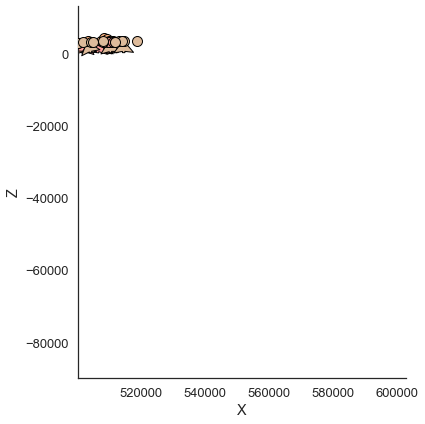

In [72]:
gp.plot.plot_data(geo_model, series='Default series')

In [73]:
gp.set_interpolator(geo_model, theano_optimizer='fast_run')    

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                                    values
range                              184081
$C_o$                         8.06808e+08
drift equations  [3, 3, 3, 3, 3, 3, 3, 3]


In [74]:
gp.compute_model(geo_model)

../../gempy/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')



Lithology ids 
  [23. 23. 23. ... 10. 17. 17.] 

328.0


ValueError: cannot reshape array of size 33425 into shape (191,174)

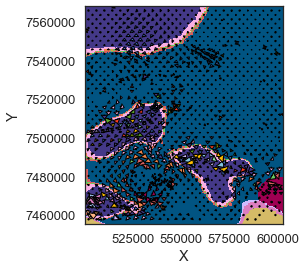

In [76]:
gp.plot.plot_map(geo_model, contour_lines=False)

In [77]:
%debug

> /Users/varga/PycharmProjects/gempy/gempy/plot/visualization_2d.py(556)extract_section_lines()
    554             if section_name == 'topography':
    555                 block = block.reshape(shape)
--> 556             else:
    557                 block = block.reshape(shape).T
    558 

ipdb> block
array([0.90039976, 0.90080479, 0.90120792, ..., 0.54519054, 0.54512574,
       0.54504204])
ipdb> block.shape
(33425,)
ipdb> 191*174
33234
ipdb> exit
